In [1]:
from __future__ import absolute_import, division, print_function

import sys
import os
import time
import pickle
from math import ceil, floor, sqrt

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from IPython.display import Image

import tensorflow as tf

from sklearn import model_selection,preprocessing
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD, Adam
from keras.regularizers import l1,l2, l1_l2
from keras.models import load_model
from keras.utils import plot_model, np_utils

# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from dataset import Dataset
from database import Database
from sample import Sample
from sample_detector import SampleDetector

# matplotlib.get_backend()
%matplotlib inline

# use gpu
print('GPUs:',K.tensorflow_backend._get_available_gpus())
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


GPUs: ['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
my_database = Database(dataset_loc, database_loc, site)

In [3]:
X, Y, _X, _Y = my_database.augmented_events(transforms=['zscore'], transforms_params=[[None]], cut_time=0.7, cut_time_split=0.3, cut_freq=7.5,cut_freq_min=2.5, time_err=0.3,noise=True, test=False)
__X, __Y = my_database.augmented_data(X,Y,_X,_Y)

/home/othniel/wdml/data/databases/awdEvents1/marion/marion_h5/['zscore']_[[None]]_[0.7, 0.3, 7.5, 2.5, 0.3]_True/train
samples:  8935


100%|██████████| 8935/8935 [00:02<00:00, 3884.08it/s]


In [4]:
freq_len, time_len = __X[0].shape
data = __X.reshape(len(__X),freq_len*time_len)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
data = data.reshape((len(data),1,freq_len,time_len))
evt = np_utils.to_categorical(__Y)
print(__X.shape, __Y.shape)
print(data.shape,evt.shape)

(13417, 48, 108) (13417,)
(13417, 1, 48, 108) (13417, 5)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 16, 48, 108)       800       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 48, 108)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 48, 108)       30992     
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 48, 108)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 48, 108)        56456     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 24, 54)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 24, 54)         14116     
__________

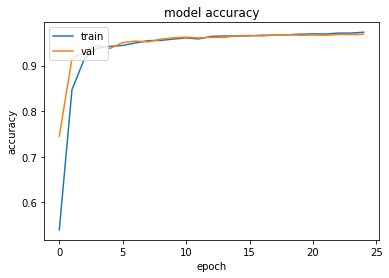

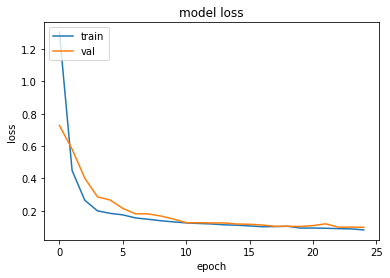

In [6]:
model = Sequential()
model.add(Conv2D(16,(7,7), input_shape=(1,freq_len, time_len),
                    padding='same', activation='relu',data_format='channels_first'))
model.add(Dropout(0.6))
model.add(Conv2D(16, (11,11), activation='relu', padding='same',data_format='channels_first'))
model.add(Dropout(0.7))
model.add(Conv2D(8, (21,21), activation='relu', padding='same',data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
model.add(Conv2D(4, (21,21), activation='relu', padding='same',data_format='channels_first'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

#compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

# fit model
history = model.fit(data, evt, validation_split=0.3, epochs=epochs, batch_size=250, shuffle=True)
print(history.history.keys())

# summarize history for accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'

# save scaler
standard_scaler = {"scaler": scaler}
scaler_path = os.path.join(database_loc,site,'scaler.pickle')
pickle.dump( standard_scaler, open(scaler_path, "wb" ) )

model_path = os.path.join(database_loc,site,'model.h5')
model.save(model_path)

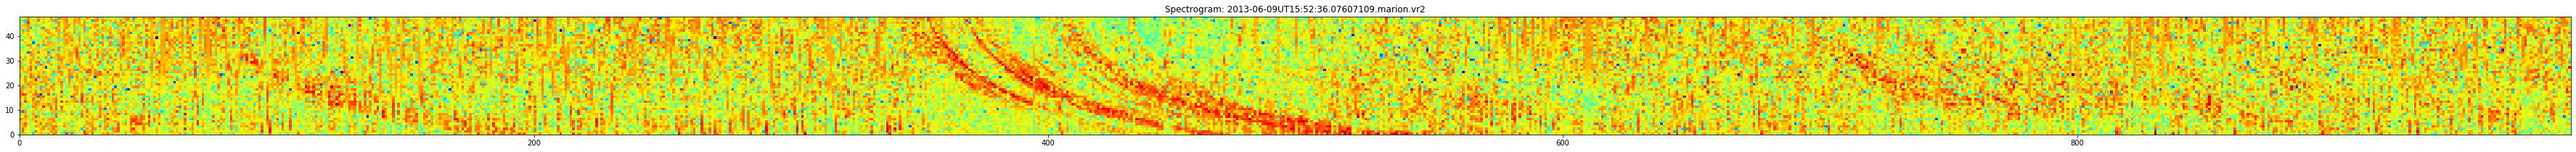

In [6]:
dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
scaler_path = os.path.join(database_loc,site,'scaler.pickle')
model_path = os.path.join(database_loc,site,'model.h5')

my_database = Database(dataset_loc, database_loc, site)
my_sample = SampleDetector(dataset_loc, site, np.random.choice(my_database.get_test(),1)[0])
# file = '2013-07-25UT04:30:47.73731922.marion.vr2'
# file= '2013-06-25UT14:04:42.60451922.marion.vr2'
# file = '2013-01-27UT00:58:07.81987602.marion.vr2'   # use this in research
# file = '2013-07-02UT14:23:00.07651914.marion.vr2'
# file = '2013-07-02UT14:23:00.07651914.marion.vr2'
# file = '2013-07-07UT14:34:37.06211914.marion.vr2'
# file = '2013-06-09UT12:52:37.22969609.marion.vr2'
# file = '2013-05-18UT13:22:09.68232156.marion.vr2'
# my_sample = SampleDetector(dataset_loc, site,file)
my_sample.apply_transform(['slice', 'zscore'],[[2.5,10],[None]])
time_err=0.2
diff_err=0.3
freq_size = 3
size = (freq_size*my_sample.get_time_freq_ratio(dec=0), freq_size)
my_sample.spectrogram_plot(figsize=size, zlabel='sprectrum magnitude [dB]', xaxis=False, yaxis=False,
                           title="Spectrogram: "+my_sample.get_file(), cmap='jet', cmap_show=False)

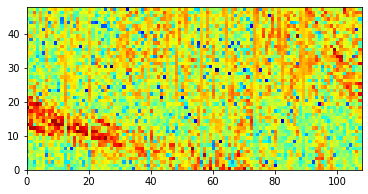

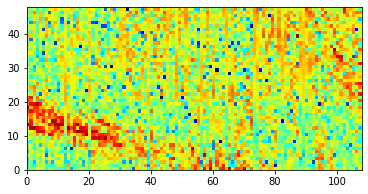

0

In [16]:
ix = 250
spec=my_sample.get_spectrogram()[:,ix:ix+time_len]
plt.figure(figsize=(6,3));plt.pcolormesh(spec,cmap='jet');plt.show();
_spec = spec.reshape(1,freq_len*time_len)
_spec = scaler.transform(_spec)
_spec = _spec.reshape(1,1,freq_len,time_len)
plt.figure(figsize=(6,3));plt.pcolormesh(_spec[0][0],cmap='jet');plt.show();
to_evt = lambda x: 1 if x==1 else 0
to_evt(np.argmax(model.predict(_spec)[0]))

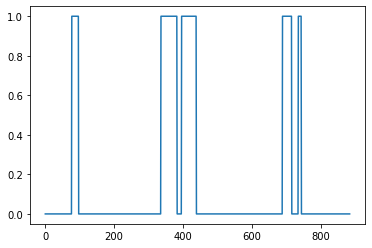

In [8]:
def output_pulses(sample, kernel_shape,scaler, model):
    output = []
    freq_len,time_len = kernel_shape
    to_evt = lambda x: 1 if x==1 else 0
    my_spec = sample.get_spectrogram()
    for ix in range(my_spec.shape[1]-time_len+1):
        spec = my_spec[:,ix:ix+time_len]
        spec = spec.reshape(1,freq_len*time_len)
        spec = scaler.transform(spec)
        spec = spec.reshape(1,1,freq_len,time_len)
        output.append(to_evt(np.argmax(model.predict(spec)[0])))
    return np.array(output)


asd = output_pulses(my_sample, kernel_shape=[48,108],
                       scaler=pickle.load( open( scaler_path, "rb" ) )['scaler'], model=load_model(model_path))
plt.figure();plt.plot(asd);plt.show()